In [23]:
import numpy as np
import pandas as pd
import pickle
import torch

from util import is_json, parse_har, write_har, postprocess_har
from trace_gen import process_event, gen_trace
from feature_gen import gen_feature
from gen_types import Event, System
from plotter import plot_frequencies

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
base_path = "cs.uchicago.edu"

In [22]:
# ---------------------
num_worker = 1
num_user = 1
mission_hour = 1
# ---------------------

mission_minutes = mission_hour*60
mission_seconds = mission_hour*60*60

# ---------------------

aggregate_har, sys = gen_trace(base_path, num_user, mission_minutes, num_worker)

Starting proxy
Proxy started
Starting driver 0
Initialized, generating trace
User 0 done, remaining 0 users
Done, aggregating har


AttributeError: 'list' object has no attribute 'keys'

In [10]:
test_pdf = postprocess_har(aggregate_har, base_path)

f = open("user_{}_hour_{}_{}.pandas".format(num_user, mission_hour, base_path), "wb")
pickle.dump(test_pdf, f)
f.close()

In [11]:
test_pdf.head(40)

,url,start_time,response_code,body_size,rtt,relative
5,https://gatech.edu/,2023-11-27 06:23:41.921253-06:00,301,231,167,0
6,https://www.gatech.edu/,2023-11-27 06:23:42.016253-06:00,403,919,73,1


In [ ]:
url_pdf = test_pdf.groupby('url').size().sort_values(ascending=False)
url_pdf.head(50)

In [24]:
# Load the HAR dict pickle file
gatech_har = pickle.load(open("user_200_hour_4_cs.uchicago.edu.har", "rb"))

In [28]:
gatech_processed = postprocess_har(gatech_har, base_path)

In [29]:
url_pdf = gatech_processed.groupby('url').size().sort_values(ascending=False)
url_pdf.head(20)

url
https://cs.uchicago.edu/                                                                                     748
https://howto.cs.uchicago.edu/lib/exe/js.php?t=dokuwiki&tseed=ec22f390edf26eae4ffeee9e97521674               599
https://howto.cs.uchicago.edu/lib/exe/jquery.php?tseed=f0349b609f9b91a485af8fd8ecd4aea4                      589
https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-Black_Web.woff2                     391
https://cs.uchicago.edu                                                                                      373
https://cs.uchicago.edu/wp-content/plugins/gravityforms/css/basic.min.css?ver=2.5.16                         339
https://cs.uchicago.edu/wp-content/uploads/2021/12/cropped-UChicagoShield_faviconArtboard-1-1-192x192.png    330
https://cs.uchicago.edu/wp-content/uploads/2021/11/UCCS-Color.svg                                            311
https://cs.uchicago.edu/wp-content/plugins/gravityforms/css/theme-ie11.min.css?ver=2.5.16   

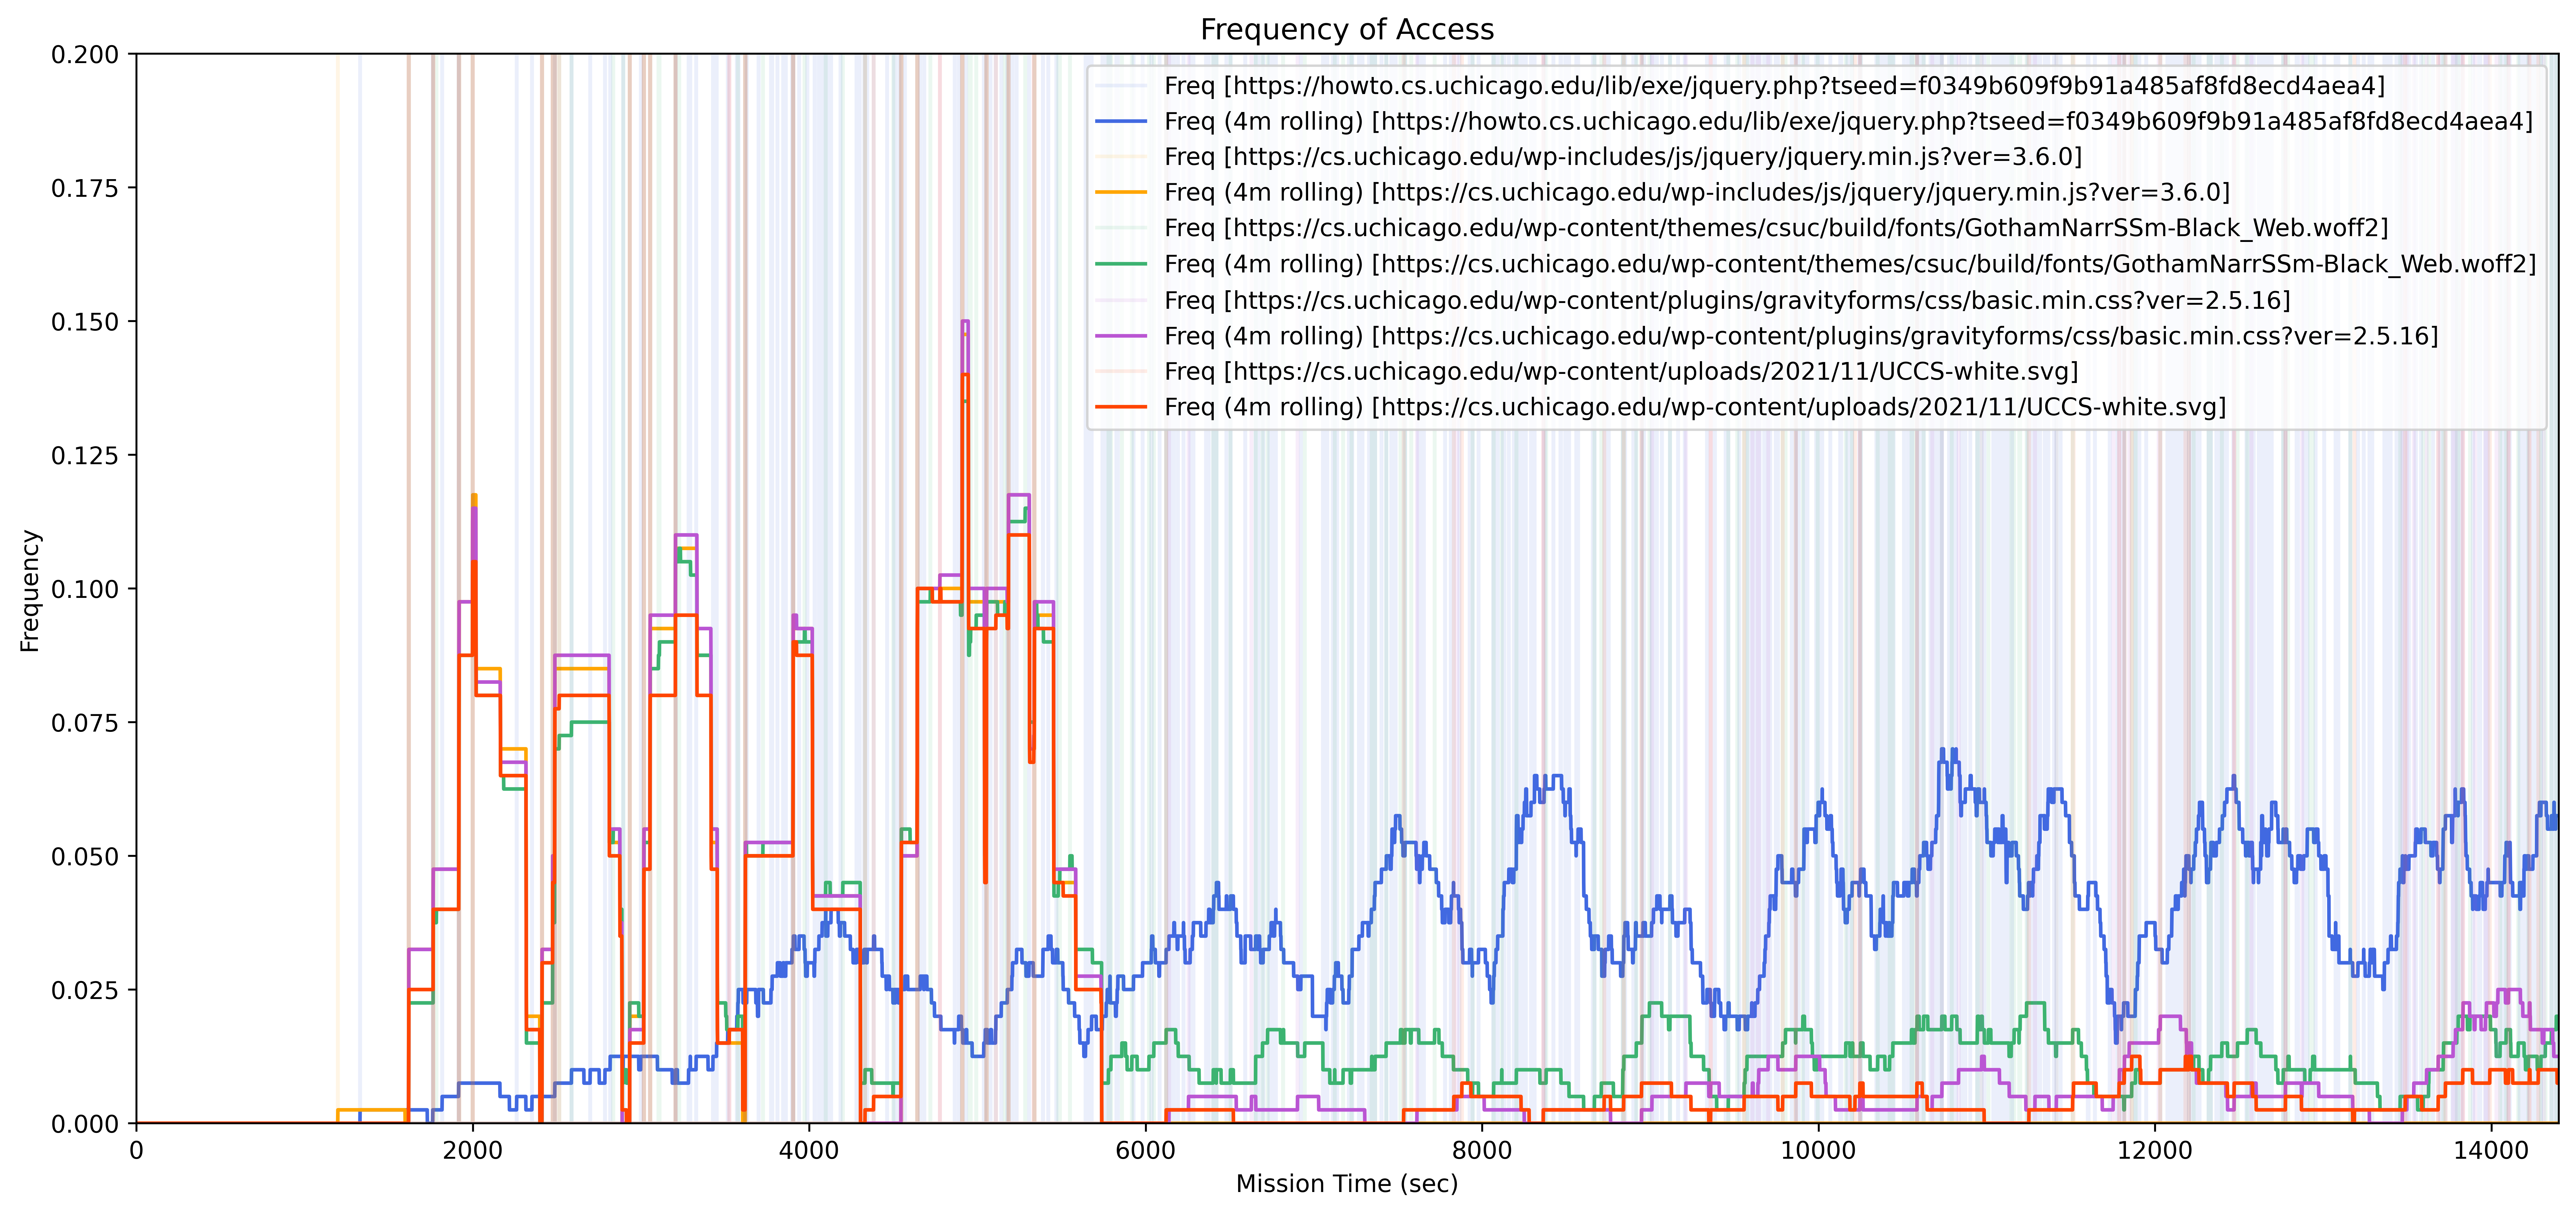

In [43]:
plot_urls = [
    "https://howto.cs.uchicago.edu/lib/exe/jquery.php?tseed=f0349b609f9b91a485af8fd8ecd4aea4",
    # "https://howto.cs.uchicago.edu/lib/exe/js.php?t=dokuwiki&tseed=ec22f390edf26eae4ffeee9e97521674",
    "https://cs.uchicago.edu/wp-includes/js/jquery/jquery.min.js?ver=3.6.0",
    "https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-Black_Web.woff2",
    "https://cs.uchicago.edu/wp-content/plugins/gravityforms/css/basic.min.css?ver=2.5.16",
    "https://cs.uchicago.edu/wp-content/uploads/2021/11/UCCS-white.svg"
    # "https://cs.uchicago.edu/wp-includes/css/dashicons.min.css?ver=5.9",
    # "https://cs.uchicago.edu/wp-content/uploads/2022/01/2653-1600x900-1-527x332.jpeg",
    # "https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-BookItalic_Web.woff2"
]

frequency_pdfs = plot_frequencies(
    gatech_processed,
    plot_urls,
    12*60*60,
    400,
    (0,4*3600),
    (0,0.20)
)

In [ ]:
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_train(freq_pdf, seq_length):
    series = freq_pdf['count_rolling'].to_numpy()
    xs, ys = [], []
    for i in range(len(series) - seq_length - 1):
        xs.append(series[i:(i+seq_length)])
        ys.append(series[i+seq_length])
        
    return torch.from_numpy(np.array(xs)).float().to(device).unsqueeze(-1), torch.from_numpy(np.array(ys)).float().to(device)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal(param)
                
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 4
num_layers = 2
output_size = 1
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

learning_rate = 1e-3
num_epochs = 20

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

window_size=200
X, Y = gen_train(frequency_pdfs[0], window_size)

In [ ]:
test_np = frequency_pdfs[0]['count_rolling'].to_numpy()
test_np[4200:4210]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset_train = TensorDataset(X, Y)
dataloader = DataLoader(dataset_train, batch_size=512, shuffle=True)

In [ ]:
losses = []
for epoch in range(num_epochs):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        # print(y_batch)
        outputs = model(x_batch)
        # print(outputs)
        
        y_batch = y_batch.reshape(outputs.shape)
        
        optimizer.zero_grad()
        loss = criteria(outputs, y_batch) * 200
        loss.backward()
        optimizer.step()
        
    print("Epoch: {}/{}, Loss: {:.8f}".format(epoch+1, num_epochs, loss.item()))
    losses.append(loss.item())

import matplotlib.pyplot as plt

plt.plot(range(0, num_epochs), losses)

In [ ]:
def infer_plot_pred(test_pdf):
    test_X, test_Y = gen_train(test_pdf, window_size)

    dataset_test = TensorDataset(X)
    dataloader_test = DataLoader(dataset_test, batch_size=64)

    y_test_preds = []
    for id_batch, (x_batch) in enumerate(dataloader_test):
        y_pred = model(x_batch[0])
        y_pred = y_pred.flatten().cpu().tolist()
        y_test_preds += y_pred
    
    plt.figure(figsize=(30, 4), dpi=200)
    plt.plot(test_pdf['count_rolling'], label="True Freq")
    plt.plot([0]*window_size + y_test_preds, label="Prediction")
    plt.xlim((0,7500))
    plt.ylim((0, 3))
    plt.legend(loc='upper right')

infer_plot_pred(frequency_pdfs[0])
infer_plot_pred(frequency_pdfs[1])

In [ ]:
plot_urls = [
    "https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-Black_Web.woff2",
    "https://cs.uchicago.edu/",
    # "https://cs.uchicago.edu/wp-includes/css/dashicons.min.css?ver=5.9",
    # "https://cs.uchicago.edu/wp-content/uploads/2022/01/2653-1600x900-1-527x332.jpeg",
    # "https://cs.uchicago.edu/wp-content/themes/csuc/build/fonts/GothamNarrSSm-BookItalic_Web.woff2"
]

plot_frequencies(
    test_pdf,
    plot_urls,
    mission_seconds,
    240
)

In [ ]:
load_path = "../data/cs.uchicago.edu/"
fpd = gen_feature(load_path)
fpd.head(5)